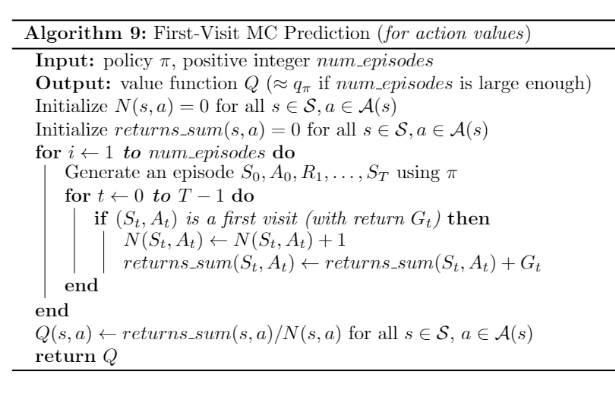

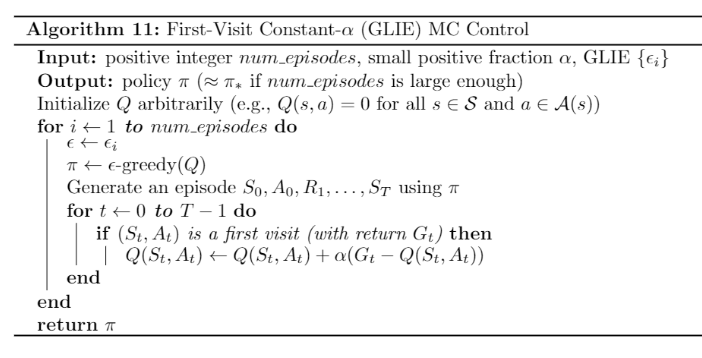

In [ ]:
import gym
import numpy as np
from collections import defaultdict

In [ ]:
env = gym.make('Blackjack-v0')
env.observation_space, env.action_space, env.action_space.n

(Tuple(Discrete(32), Discrete(11), Discrete(2)), Discrete(2), 2)

In [ ]:
def get_stochastic_results(bj_env):
    episode = []
    state = bj_env.reset()
    
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break

    return episode

In [ ]:
for i in range(3):
    print(get_stochastic_results(env))

[((20, 10, False), 1, -1.0)]
[((13, 4, False), 1, 0.0), ((19, 4, False), 0, 0.0)]
[((12, 1, False), 1, -1.0)]


In [ ]:
# every-visit
def monte_carlo_evaluation(env, episodes, stochastic_fn, gamma=0.7):
    nA = env.action_space.n
    G = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    Q = defaultdict(lambda: np.zeros(nA))
    
    for ep in range(1, episodes + 1):
        states, actions, rewards = zip(*stochastic_fn(env))
        discounts = np.array([gamma ** i for i in range(len(rewards) + 1)])

        for i, s in enumerate(states):
            G[s][actions[i]] += sum(rewards[i:] * discounts[:-(i+1)])
            N[s][actions[i]] += 1.0
            Q[s][actions[i]] = G[s][actions[i]] / N[s][actions[i]]

    return Q

In [ ]:
def get_probs(Q_s, epsilon, nA):
    pi_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    pi_s[best_a] = 1 - epsilon + (epsilon / nA)

    return pi_s

In [ ]:
# every-visit
def monte_carlo_control(env, episodes, alpha, gamma, epsilon, ep_decay, min_ep):
    nA = env.action_space.n 
    Q = defaultdict(lambda: np.zeros(nA))

    for ep in range(1, episodes + 1):

        episode = []
        s = env.reset()
        while True:
            a = np.random.choice(np.arange(nA), p=get_probs(Q[s], epsilon, nA)) if s in Q else env.action_space.sample()
            next_s, r, done, info = env.step(a)
            episode.append((s, a, r))        
            s = next_s
            if done:
                break
        
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, s in enumerate(states):
            old_Q = Q[s][actions[i]]
            Q[s][actions[i]] = old_Q + alpha * (sum(rewards[i:] * discounts[:-(i+1)]) - old_Q)    

        epsilon = max(epsilon * ep_decay, min_ep)

    pi = dict((k, np.argmax(v)) for k, v in Q.items())
    return pi

In [ ]:
Q = monte_carlo_evaluation(env, 50000, get_stochastic_results)
pi = monte_carlo_control(env, 50000, 0.7, 0.9, 1, 0.999999, 0.005)

In [ ]:
def play(env, episodes, max_steps, x, is_pi):
    rewards = 0
    wins = 0
    for episode in range(episodes):
        s = env.reset()

        for step in range(max_steps):
            if is_pi:
                a = x[s]
            else:
                a = np.argmax(x[s])
                
            s, r, done, _ = env.step(a)
            rewards += r
            if done:
                break
        
        if rewards >= 0:
            wins += 1

    print(f"Score: {wins}/{episodes}")

In [ ]:
print("Monte Carlo Evaluation:")
play(env, 50, 500, Q, False)

print("")

print("Monte Carlo Control:")
play(env, 50, 500, pi, True)

Monte Carlo Evaluation:
Score: 45/50

Monte Carlo Control:
Score: 46/50
